## Imports

In [22]:
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

## definitions

In [2]:
np.random.seed(42)
NUM_FEATURE = 12
RANDOM_DATA = True

In [3]:
def get_data(red=False):
    #get red wine data  
    red_data = np.genfromtxt('../data/winequality-red.csv',delimiter=';')
    red_data = np.delete(red_data,(0),axis=0)
    red_feature = np.array([[1 for i in range(red_data.shape[0])]])
    red_y = np.array([red_data[:,11]])
    red_data = np.append(red_data[:,0:11],red_feature.T,axis=1)
    red_data = np.append(red_data,red_y.T,axis=1)
    print
    if red:
        return red_data
        #get white wine data
    white_data = np.genfromtxt('../data/winequality-white.csv',delimiter=';')
    white_data = np.delete(white_data,(0),axis=0)
    white_feature = np.array([[-1 for i in range(white_data.shape[0])]])
    white_y = np.array([white_data[:,11]])
    white_data = np.append(white_data[:,0:11],white_feature.T,axis=1)
    white_data = np.append(white_data,white_y.T,axis=1)
    #combine the 2
    data = np.append(red_data,white_data,axis=0)
    if RANDOM_DATA:
        np.random.shuffle(data)
    return data

## Data Split
split 80% training, 20% test Normalised using training data

In [4]:
def split_data(data,train_split=0.8):
    #train,test,val
    train,test = np.split(data, [int(train_split*data.shape[0])])

    train_x,train_y = np.hsplit(train,[NUM_FEATURE])
    test_x,test_y   = np.hsplit(test, [NUM_FEATURE])
    
    #remove outliers
    
    #normalise data
    for i in range(NUM_FEATURE):
        mean  = train_x[:,i].mean()
        std   = train_x[:,i].std() 

        #normalise training data
        train[:,i] = (train_x[:,i] - mean)/std
        #normalise test data  
        test[:,i] = (test_x[:,i] - mean)/std
  
    return train_x,train_y,test_x,test_y


## Loss Function Definitions
Used for working out loss and errors.

In [162]:
def square_loss(y,pred_y):
    return ((y-pred_y)**2).mean()

def mae_loss(y,pred_y):
    return abs(y-pred_y).mean()
  
def identity_loss(y,pred_y):
    N = len(y)
    error_sum = 0
    for i in range(N):
        if int(y[i]) != int(pred_y[i]):
            error_sum += 1
    return error_sum/N

## Cross-Validation 

In [163]:
def cross_validation(train_x,train_y,model,k=10,loss=square_loss):
    #split into K folds
    data = np.concatenate((train_x,train_y),axis=1)
    kf = KFold(n_splits=k)

    error_sum = 0
    for train,test in kf.split(data):
        train_data  = np.array(data)[train]  
        test_data   = np.array(data)[test]  
        train_x, train_y  = np.hsplit(train_data,[NUM_FEATURE])
        test_x , test_y   = np.hsplit(test_data,[NUM_FEATURE])
        model.fit(train_x,train_y)
        pred_y = model.predict(test_x)
        error_sum += loss(test_y,pred_y)

    return error_sum/k    

## Regression Models

In [164]:
def sk_lin_regr(data):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.LinearRegression() 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_lasso_regr(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Lasso(alpha) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Lasso MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_ridge_regr(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Ridge(alpha) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(train_x)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Ridge MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_elastic_regr(data,alpha=0.1, l1_ratio=0.5):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.ElasticNet(alpha, l1_ratio) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Elastic Net MAE: ",mean_absolute_error(test_y,pred_y))
    return regr


## Training Graph

In [299]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 100)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Absolute Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='neg_mean_absolute_error', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training Error")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation Error")

    plt.legend(loc="best")
    return plt

In [300]:
def plot_validation_curve(estimator,X,y, title, scoring, param_name,param_range):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=10, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Error")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

(sk) linear regression MAE:  0.5654201128286696
[[-0.56829294 -0.56045205 -0.56045205 -0.56045205 -0.56045205 -0.56045205
  -0.56045205 -0.56045205 -0.56045205 -0.56045205]
 [-0.56340715 -0.56305491 -0.56305491 -0.56305491 -0.56305491 -0.56305491
  -0.56305491 -0.56305491 -0.56305491 -0.56305491]
 [-0.56498306 -0.56543559 -0.5594333  -0.5594333  -0.5594333  -0.5594333
  -0.5594333  -0.5594333  -0.5594333  -0.5594333 ]
 [-0.56840778 -0.56644979 -0.55248402 -0.55248402 -0.55248402 -0.55248402
  -0.55248402 -0.55248402 -0.55248402 -0.55248402]
 [-0.57211182 -0.56715332 -0.55833074 -0.55833074 -0.55833074 -0.55833074
  -0.55833074 -0.55833074 -0.55833074 -0.55833074]
 [-0.57636107 -0.57264897 -0.57143331 -0.57143331 -0.57143331 -0.57143331
  -0.57143331 -0.57143331 -0.57143331 -0.57143331]
 [-0.58648611 -0.58540389 -0.57667023 -0.57667023 -0.57667023 -0.57667023
  -0.57667023 -0.57667023 -0.57667023 -0.57667023]
 [-0.58306248 -0.58161946 -0.58213775 -0.58213775 -0.58213775 -0.58213775
  -0

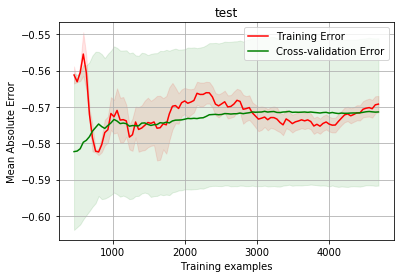

In [301]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_lin_regr(data)
plot_learning_curve(model, "test", train_x, train_y,cv=10)
plt.show()
 

(sk) linear regression Ridge MAE:  0.5525660069525826


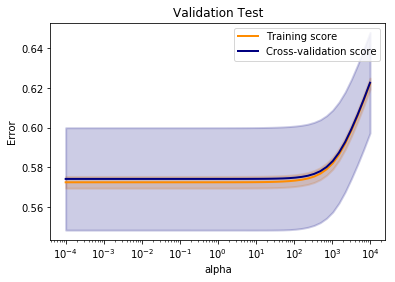

In [168]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_ridge_regr(data,0.1)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','alpha',np.logspace(-4,4,50))
plt.show()

(sk) linear regression Lasso MAE:  0.606292029555768


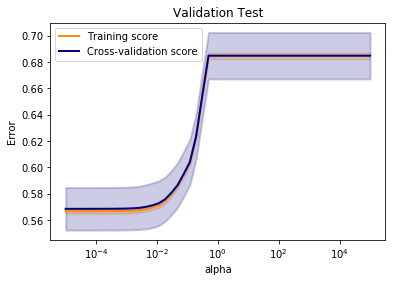

In [169]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_lasso_regr(data,0.1)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','alpha',np.logspace(-5,5,50))
plt.show()

(sk) linear regression Elastic Net MAE:  0.5702611331026207


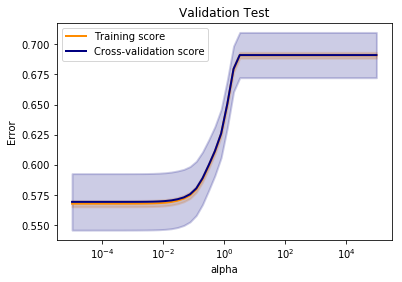

In [170]:
data = get_data(False) 
#df = pd.DataFrame(data)
#print(df)
train_x,train_y,test_x,test_y = split_data(data)
model = sk_elastic_regr(data,0.0001,0.15)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','alpha',np.logspace(-5,5,50))
plt.show()

(sk) linear regression Elastic Net MAE:  0.5695897402780741


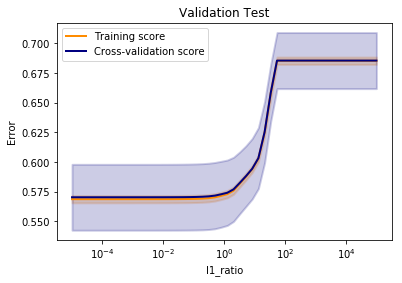

In [171]:
data = get_data(False) 
#df = pd.DataFrame(data)
#print(df)
train_x,train_y,test_x,test_y = split_data(data)
model = sk_elastic_regr(data,0.01,0.01)
plot_validation_curve(model, train_x,train_y,'Validation Test','neg_mean_absolute_error','l1_ratio',np.logspace(-5,5,50))
plt.show()

> note, need to deal with large crossvalidation variance

# SVM

In [317]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import numpy as np

In [318]:
def cross_validation_rbf_svm(train_x,train_y,model_loss,k=10,gamma=0.1,C=1.0):
    #split into K folds
    data = np.concatenate((train_x,train_y),axis=1)
    kf = KFold(n_splits=k)

    error_sum = 0.0
    error = [0 for i in range(k)]
    i=0
    for train,test in kf.split(data):
        train_data  = np.array(data)[train]  
        test_data   = np.array(data)[test]  
        train_x, train_y  = np.hsplit(train_data,[NUM_FEATURE])
        test_x , test_y   = np.hsplit(test_data,[NUM_FEATURE])
        tmp = model_loss(train_x,train_y,test_x,test_y,gamma=gamma,C=C)
        error_sum += tmp
        error[i] = tmp

    #return error_sum/k    
    return error

In [319]:
def plot_validation_curve_svm(model,X,y, title, param_name, param_range):
    
    cross_val_score = np.array([])
    
    for val in param_range:
        if param_name == "gamma":
            cross_val_score = np.append(cross_val_score,cross_validation_rbf_svm(X,y,model,gamma=val))
            
    scores_mean = np.mean(cross_val_score, axis=1)
    scores_std = np.std(cross_val_score, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Error")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, scores_mean, label="Training score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, scores_mean - scores_std,
                     scores_mean + scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [320]:
def bin_classify_y(y,val):

    tmp = np.array([[0] for i in range(len(y))])

    for i in range(len(y)):
        if int(y[i][0]) >= val:
            tmp[i][0] =  1
        else:
            tmp[i][0] = -1
    return tmp

In [321]:
def bin_predict_y(y,n):
    if n==1:
        return 0.5*(y[n]+1)
    elif n==9:
        return n + 0.5*(y[n]+1)
    elif y[n-1] == 1 and y[n]==-1 and y[n+1]==-1:
        return n-1
    elif y[n] == 1:
        return bin_predict_y(y,n+1)
    elif y[n] == -1:
        return bin_predict_y(y,n-1)

## RBF Kernel

In [322]:
def sk_rbf_SVM(gamma=0.1,C=0.5):
    svm = SVC(kernel="rbf",C=C,gamma=gamma)
    return svm

def sk_rbf_SVM_multi(train_x,train_y,test_x,test_y,gamma=0.1,C=0.5):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_rbf_SVM(gamma,C) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        #print("N: ", n)
        #for i in range(len(train_y)):
        #    print("y: ",train_y[i],"bin class: ",bin_classify_y(train_y,n)[i],"n: ",n)
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        pred_y = models[i].predict(train_x)
        #print(pred_y[0])
        #print("(sk) SVM level Accuracy: ",(1-identity_loss(bin_classify_y(train_y,n),pred_y)))
        i += 1
    #predict y
    pred_y_raw = [(model.predict(train_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    #for y in pred_y_raw:
    #    print(y)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(11-higher)]) for j in range(len(pred_y_raw))])
    #print(pred_y_raw[0])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    #for i in range(len(pred_y)):
    #for i in range(len(pred_y)):
    #    if pred_y[i] != train_y[i]:
    #        print("predicted value: ",pred_y[i],", actual: ",train_y[i],pred_y_raw[i])
    #print("(sk) SVM level Accuracy: ",(1-identity_loss(train_y,pred_y)))
    return identity_loss(train_y,pred_y)

In [ ]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
print("CV error: ",cross_validation_svm(train_x,train_y,sk_rbf_SVM_multi))
plot_validation_curve_svm(sk_rbf_SVM_multi,train_x,train_y, "SVM RBF error", 'gamma', np.logspace(-5,0,5))
plt.show()

CV error:  0.40215514818177756


In [315]:
plt.show()

In [308]:
def sk_lin_SVM(C=0.5):
    svm = SVC(kernel="linear",C=C,gamma=gamma)
    return svm

def sk_lin_SVM_multi(train_x,train_y,test_x,test_y,C=0.5):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_rbf_SVM(C) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        pred_y = models[i].predict(train_x)
        i += 1
    #predict y
    pred_y_raw = [(model.predict(train_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(11-higher)]) for j in range(len(pred_y_raw))])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    print("(sk) SVM level Accuracy: ",(1-identity_loss(train_y,pred_y)))
    return identity_loss(train_y,pred_y)

In [196]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
sk_lin_SVM_multi(train_x,train_y,test_x,test_y,C=0.5)

(sk) SVM level Accuracy:  0.54


In [ ]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
train_y = bin_classify_y(train_y,5)
test_y = bin_classify_y(test_y,5)
print(train_y)
model = sk_lin_SVM(data)
plot_validation_curve(model, train_x,train_y.ravel(),'Validation Test','neg_mean_absolute_error','gamma',np.logspace(-2,3,5))
plt.show()

> do for linear, rbf and one other kernel 

> try output classification technique


# Data Analysis

In [31]:
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

NUM_FEATURE = 12

## Correlation Matrix

In [32]:
def normalise(data):
    return (data - data.mean())/data.std()

def normalise_all(data):
    for i in range(NUM_FEATURE):
        data[:,i] = normalise(data[:,i])
    return data

In [33]:
def get_correlation_matrix(data,fig_num):
    data = np.delete(data,-1,axis=1)
    df = pd.DataFrame(data=data)
    fig = plt.figure(fig_num)
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr())
    fig.colorbar(cax)
    return

In [34]:
def visualise_data(x,y,fig_num):
    sz = np.array([0.2 for x in range(len(y))])
    fig = plt.figure(fig_num)
    for i in range(NUM_FEATURE):
        ax = fig.add_subplot(2,6,i+1)
        x_norm = normalise(x[:,i])
        ax.scatter(x_norm,y,sz)
        ax.set_ylim([0,10])
        ax.set_xlim(xmin=0)

    return

In [35]:
def get_data_plot(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])
    visualise_data(x,y,fig_num)
    return

In [36]:
def get_corr_coef(x,y):
    coef_array = np.corrcoef(np.transpose(x),np.transpose(y))
    return coef_array[0,1]


def get_data_output_correlation_plot(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])
    x = normalise_all(x)
    corr = np.array([get_corr_coef(x[:,i],y) for i in range(NUM_FEATURE)])
    x_axis = np.arange(NUM_FEATURE)

    plt.figure(fig_num)
    plt.bar(x_axis,corr)
    return

In [37]:
def get_output_dist(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])

    fig = plt.figure(fig_num)
    sns.distplot(np.transpose(y))

    return

def get_feature_dist(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])

    x = normalise_all(x)

    fig = plt.figure(fig_num)

    for i in range(NUM_FEATURE):
        ax = fig.add_subplot(2,6,i+1)
        sns.distplot(np.transpose(x[:,i]))

    return

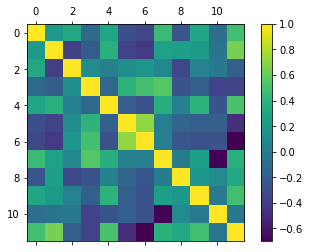

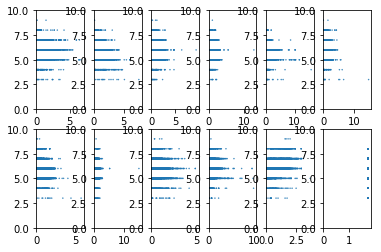

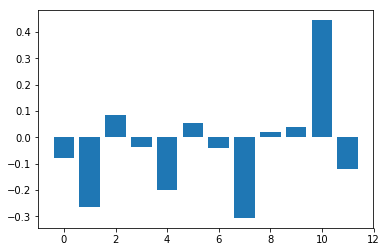

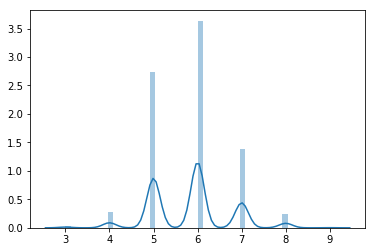

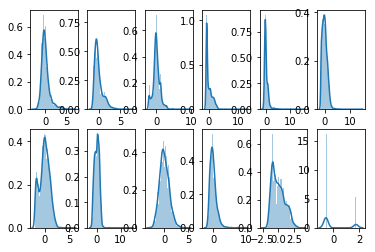

In [38]:
data = get_data()
get_correlation_matrix(data,1)
get_data_plot(data,2)
get_data_output_correlation_plot(data,3)
get_output_dist(data,4)  
get_feature_dist(data,5)

# TODO
 -  sort out classification problem (one vs all, and decide on boundaries)
 -  explore what C term means
 -  try different SVM kernels
 -  justify SVM choice
 -  equations for everything
 -  justify loss functions
 -  Appendix for Data Analysis
 -  outlier removal (justify with results without it)
 -  gradient descent on parameters (optional)